## IMPORTACIÓN DE LIBRERÍAS

In [7]:
import os
os.environ["PYSENTIMIENTO_BACKEND"] = "torch"
import spacy
from pysentimiento import create_analyzer
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

## LECTURA DE ARCHIVO CON COMENTARIOS

In [8]:
# Carga
df = pd.read_excel(r"C:\Users\9 ----- SIG\Downloads\reseñas.xlsx")
df.head(2)

,comentario
0,television Nevir\n\nNada bueno se me fue ka pa...
1,Dinero tirado a la basura con esta compra\n\nH...


In [9]:
# Limpieza breve

df["comentario"] = df["comentario"].str.lower()
# Reemplazamos los saltos de línea (\n) por un espacio simple
df['comentario'] = df['comentario'].str.replace(r'\n', ' ', regex=True)
# Quitar espacios dobles que hayan quedado
df['comentario'] = df['comentario'].str.replace(r'\s+', ' ', regex=True).str.strip()

In [10]:
df.head(1)

,comentario
0,television nevir nada bueno se me fue ka panta...


### ANÁLISIS DE SENTIMIENTO DE UN COMENTARIO DE PRUEBA

In [11]:
# Inicializamos el cerebro de sentimiento
analizador = create_analyzer(task="sentiment", lang="es")

# Tomamos una reseña de ejemplo del DataFrame
texto_ejemplo = df['comentario'].iloc[0]

# Analizamos
resultado_ia = analizador.predict(texto_ejemplo)

print(f"Reseña original: {texto_ejemplo}")
print(f"Sentimiento detectado: {resultado_ia.output}")
print(f"Confianza (Probabilidades): {resultado_ia.probas}")

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Reseña original: television nevir nada bueno se me fue ka pantalla en menos de 8 meses y no he recibido respuesta del fabricante
Sentimiento detectado: NEG
Confianza (Probabilidades): {'NEG': 0.9429960250854492, 'NEU': 0.05240936577320099, 'POS': 0.004594577010720968}


### ANÁLISIS LINGUISTICO DE PRUEBA

In [12]:
# Carga modelo en español
nlp = spacy.load("es_core_news_md", disable=["ner", "parser"])

# Procesamos el texto
doc = nlp(texto_ejemplo)

print(f"{'Palabra':<12} | {'Lema':<12} | {'Categoría':<10} | {'¿Es Stopword?'}")
print("-" * 55)

for token in doc:
    # Mostramos los detalles de cada palabra
    print(f"{token.text:<12} | {token.lemma_:<12} | {token.pos_:<10} | {token.is_stop}")

Palabra      | Lema         | Categoría  | ¿Es Stopword?
-------------------------------------------------------
television   | television   | PROPN      | False
nevir        | nevir        | VERB       | False
nada         | nada         | ADV        | True
bueno        | bueno        | ADJ        | True
se           | él           | PRON       | True
me           | yo           | PRON       | True
fue          | ser          | AUX        | True
ka           | ka           | NOUN       | False
pantalla     | pantalla     | NOUN       | False
en           | en           | ADP        | True
menos        | menos        | ADV        | True
de           | de           | ADP        | True
8            | 8            | NUM        | False
meses        | mes          | NOUN       | False
y            | y            | CCONJ      | True
no           | no           | ADV        | True
he           | haber        | AUX        | True
recibido     | recibir      | VERB       | False
respuesta    | r

In [13]:
# Filtrar solo lo relevante (Sustantivos y Adjetivos) que no sea ruido
palabras_clave = [token.lemma_ for token in doc if token.pos_ in ["NOUN", "ADJ"] and not token.is_stop]

print("Conceptos clave para el reporte de esta reseña:")
print(palabras_clave)

Conceptos clave para el reporte de esta reseña:
['ka', 'pantalla', 'mes', 'respuesta', 'fabricante']


### APLICACIÓN A TODO EL ARCHIVO

In [ ]:
# Creamos listas vacías para guardar resultados
sentimientos = []
prob_pos = []
prob_neu = []
prob_neg = []
keywords = []

for i in range(len(df)):
    texto = str(df['comentario'].iloc[i])
    
    # --- PROCESAMIENTO DE SENTIMIENTO ---
    resultado_ia = analizador.predict(texto)
    
    # 1. Guardamos la etiqueta principal
    sentimientos.append(resultado_ia.output)
    
    # 2. Extraemos las 3 probabilidades del diccionario .probas
    # Usamos round(x, 4) para que no sean números tan largos
    prob_pos.append(round(resultado_ia.probas['POS'], 2))
    prob_neu.append(round(resultado_ia.probas['NEU'], 2))
    prob_neg.append(round(resultado_ia.probas['NEG'], 2))
    
    # --- PROCESAMIENTO DE TEXTO (spaCy) ---
    doc = nlp(texto.lower())
    # Filtramos sustantivos y adjetivos que no sean stop words
    lemas = [t.lemma_ for t in doc if t.pos_ in ["NOUN", "ADJ"] and not t.is_stop]
    keywords.append(", ".join(lemas))
    
    # Monitor de progreso simple
    if (i + 1) % 10 == 0:
        print(f"Progreso: {i + 1}/{len(df)} reseñas analizadas.")

# Creamos el DataFrame de visualización
# Asignamos las listas al DataFrame
df['Sentimiento_Final'] = sentimientos
df['Prob_Positivo'] = prob_pos
df['Prob_Neutral'] = prob_neu
df['Prob_Negativo'] = prob_neg
df['Analisis_Keywords'] = keywords

In [15]:
df[['comentario', 'Sentimiento_Final', 'Prob_Positivo', 'Prob_Neutral', 'Prob_Negativo', 'Analisis_Keywords']].head(3)

,comentario,Sentimiento_Final,Prob_Positivo,Prob_Neutral,Prob_Negativo,Analisis_Keywords
0,television nevir nada bueno se me fue ka panta...,NEG,0.0,0.05,0.94,"ka, pantalla, mes, respuesta, fabricante"
1,dinero tirado a la basura con esta compra horr...,NEG,0.0,0.02,0.97,"dinero, tirado, basura, compra, horrible, ingl..."
2,solo llega una unidad cuando te obligan a comp...,NEG,0.0,0.02,0.98,"unidad, unidad, forma, autentico, estafa"


### PUNTOS DE DOLOR COMENTARIOS NEGATIVOS

In [16]:
# Filtramos solo las reseñas que la IA marcó como Negativas
df_negativo = df[df['Sentimiento_Final'] == 'NEG'].copy()

# conteo de palabras negativas
from collections import Counter

palabras_neg = []
for lista in df_negativo['Analisis_Keywords']:
    # Separamos los lemas de la cadena y los sumamos a la lista maestra
    palabras_neg.extend(lista.split(", "))

# Contamos las 10 más frecuentes
top_quejas = Counter(palabras_neg).most_common(10)

print("¿De qué se quejan los clientes? (Top 10 temas negativos):")
for palabra, conteo in top_quejas:
    print(f"- {palabra}: {conteo} menciones")

¿De qué se quejan los clientes? (Top 10 temas negativos):
- producto: 455 menciones
- calidad: 317 menciones
- malo: 310 menciones
- mes: 238 menciones
- dinero: 151 menciones
- vendedor: 146 menciones
- amazon: 140 menciones
- pantalla: 113 menciones
- pedido: 109 menciones
- compra: 107 menciones


### MATRIZ DE AMBIGUEDAD

Comentarios donde el algoritmo de IA sufrió o tuvo muchas dudas

In [17]:
# Creamos una columna que mida la distancia entre Positivo y Negativo
# Si la diferencia es cercana a 0, el comentario es muy ambiguo
df['Diferencia_Sentimiento'] = abs(df['Prob_Positivo'] - df['Prob_Negativo'])

# Buscamos los 5 más ambiguos
comentarios_dudosos = df.sort_values('Diferencia_Sentimiento').head(5)
comentarios_dudosos[['comentario', 'Prob_Positivo', 'Prob_Negativo', 'Sentimiento_Final','Diferencia_Sentimiento']]

,comentario,Prob_Positivo,Prob_Negativo,Sentimiento_Final,Diferencia_Sentimiento
656,no funcionaba la luz la oferta era muy buena e...,0.15,0.15,NEU,0.00
1629,cuidado! no tiene nada que ver con las fotogra...,0.08,0.08,NEU,0.00
246,decepción son mucho mas grandes de lo habitual...,0.08,0.08,NEU,0.00
1641,mediocre se rompió enseguida. fácil de colocar...,0.07,0.08,NEU,0.01
694,adaptador antena wifi usb 3.0 600mbps receptor...,0.10,0.11,NEU,0.01


### NUBE DE PALABRAS UNIFICADO

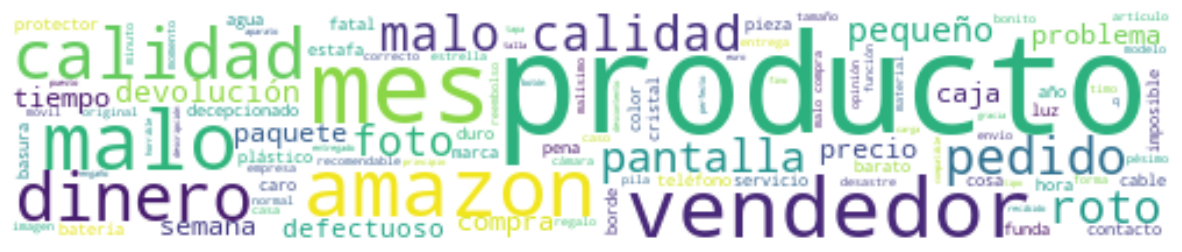

In [18]:
# 1. Unimos todas las filas de la columna de keywords en un solo string
texto_para_nube = " ".join(df['Analisis_Keywords'].astype(str))

# 2. Configuramos la nube
nube = WordCloud(
    width=500, 
    height=100, 
    background_color='white',
    colormap='viridis', # Colores estilo profesional
    max_words=100       # Solo las 100 más importantes
).generate(texto_para_nube)

# 3. La mostramos con Matplotlib
plt.figure(figsize=(15, 7))
plt.imshow(nube, interpolation='bilinear')
plt.axis("off"); # Quitamos los ejes (números de los lados)

### NUBE SEGMENTADA POR SENTIMIENTO

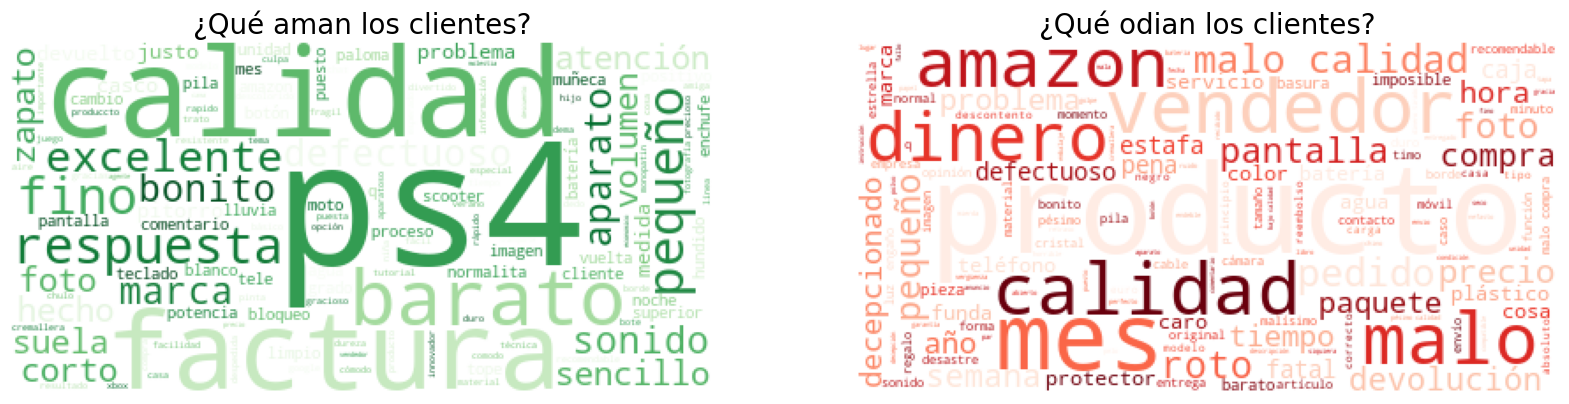

In [19]:
# --- Nube para Comentarios NEGATIVOS ---
texto_neg = " ".join(df[df['Sentimiento_Final'] == 'NEG']['Analisis_Keywords'].astype(str))
nube_neg = WordCloud(width=400, height=200, background_color='white', colormap='Reds').generate(texto_neg)
# --- Nube para Comentarios POSITIVOS ---
texto_pos = " ".join(df[df['Sentimiento_Final'] == 'POS']['Analisis_Keywords'].astype(str))
nube_pos = WordCloud(width=400, height=200, background_color='white', colormap='Greens').generate(texto_pos)
# Dibujamos ambas lado a lado
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(nube_pos)
ax[0].set_title('¿Qué aman los clientes?', fontsize=20)
ax[0].axis('off')
ax[1].imshow(nube_neg)
ax[1].set_title('¿Qué odian los clientes?', fontsize=20)
ax[1].axis('off');

### INDICADORES FINALES

In [20]:
aprobacion = (df["Prob_Positivo"].mean() - df["Prob_Negativo"].mean()) * 100
# 2. Contamos cuántos son realmente positivos vs negativos (etiquetas)
conteo_sentimientos = df["Sentimiento_Final"].value_counts()

print(f"--- REPORTE DE REPUTACIÓN ---")
print(f"Puntaje de Aprobación Neto: {aprobacion:.2f}")
print(f"Reseñas analizadas: {len(df)}")
print("-" * 30)
print(conteo_sentimientos)

--- REPORTE DE REPUTACIÓN ---
Puntaje de Aprobación Neto: -80.53
Reseñas analizadas: 1998
------------------------------
Sentimiento_Final
NEG    1789
NEU     184
POS      25
Name: count, dtype: int64
